In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statannot
from scipy import stats
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from factor_analyzer import (ConfirmatoryFactorAnalyzer,ModelSpecificationParser)
from matplotlib.cm import ScalarMappable

## Read Data

In [79]:
# Global variables
demo_war_df = pd.read_csv('demo_war_table.csv')
war_df = pd.read_csv('war_table.csv')
subjective_df = pd.read_csv('subjective_table.csv')
objective_df = pd.read_csv('objective_task_table.csv')

## Color Palette

In [82]:
colors = ['plum','violet','royalblue','lightblue','aquamarine','seagreen','mediumseagreen','lightgreen',
          'gold','wheat','coral','salmon','tomato','hotpink']

colors_warbar = ['#a3c4f3','#8eecf5','#a5ffd6','#fff3b0','#fbc4ab']

mental_color = {'purple':['#8c07dd','#B333E9','#CB5DF1','#DC93F6','#EABFFA'],
                'blue':['#0d47a1','#1976d2','#2196f3','#90caf9','#e3f2fd'],
                'turquoise':['#008083','#39a2ae','#44e5e7','#73fbd3','#c2ffee'],
                'green':['#3DA35D','#96E072'],
                'yellow':['#F9DC5C','#FCEFB4'],
                'orange':['#f3722c','#f79d65','#f9c74f'],
                'red':['#EF3C2D','#F26A4F','#eaa8a8'],
                'pink':['#FF4D6D','#FF8FA3','#ffe5ec']}

# Factor Analysis

In order to do Factor Analysis we need to convert the categorical data into a numeric version

In [86]:
war_df_factor_analysis = war_df.copy()
war_df_factor_analysis = war_df_factor_analysis[['uniqueID',
                                                 'sirens',
                                                 'reserve_duty',
                                                 'knows_victims',
                                                 'work_changes',
                                                 'news_consumption',
                                                 'worry_to_someone']]


# Each measure has range of 0-1
# max score is 6 and min score is 0
war_df_scales = {'sirens': 
                  {'Not at all': 0,
                   'Few': 1,
                   'Between 2-3 times a week': 2,
                   'Every day': 3},
                  'reserve_duty':
                  {'No': 0,
                   'Yes, I finished my reserve': 1,
                   'Yes, I still serve': 2},
                  'news_consumption': 
                  {'Not at all': 0,
                   'Two hours max': 1,
                   'Between 2 to 3 hours': 2,
                   'At least 5 hours': 3},
                  'knows_victims':
                  {'No': 0,
                   'Yes': 1},
                  'worry_to_someone':
                  {'No': 0,
                   'Yes': 1},
                 'work_changes':
                 {'Not at all': 0,
                  'Slightly': 1,
                  'Moderately': 2,
                  'A lot': 3,
                  'Extremely': 4}
                 }
war_df_scales = war_df_factor_analysis.replace(war_df_scales)
war_df_scales = war_df_scales.dropna()
war_df_scales['war_scale'] = war_df_scales[['sirens',
                                            'reserve_duty',
                                            'knows_victims',
                                            'news_consumption',
                                            'work_changes',
                                            'worry_to_someone']].sum(axis=1, numeric_only=True)
war_df_scales['war_scale_without_reserve'] = war_df_scales[['sirens',
                                                'knows_victims',
                                                'news_consumption',
                                                'work_changes',
                                                'worry_to_someone']].sum(axis=1, numeric_only=True)

In [88]:
demo_df = demo_war_df.copy()
demo_df = demo_df[['uniqueID','age','gender','prior_diagnosis','education']]
demo_df.head()

demo_df_scales = {'gender': {'female': 0, 'male': 1},
                  'education': {'high scholl': 0, 'during academy': 1, 'academic': 2},
                  'prior_diagnosis': {'no': 0,'other': 0.25,'ADHD': 0.5, 'DASS': 0.75, 'PTSD':1}}

demo_df_scales = demo_df.replace(demo_df_scales)
demo_df_scales = demo_df_scales.dropna()


In [90]:
dataset_with_new_factors = pd.merge(demo_df_scales, war_df_scales,on='uniqueID')
dataset_with_new_factors = pd.merge(dataset_with_new_factors, mental_health_factor_analysis, on='uniqueID')
dataset_with_new_factors = pd.merge(dataset_with_new_factors, objective_df, on='uniqueID')
dataset_with_new_factors
dataset_of_new_factors = dataset_with_new_factors[['uniqueID',
                                                   'age',
                                                   'gender',
                                                   'prior_diagnosis',
                                                   'education',
                                                   'war_scale',
                                                   'war_scale_without_reserve',
                                                   'reserve_duty',
                                                   'well_being',
                                                   'problems',
                                                   'emotional',
                                                   'avoidance',
                                                   'asrs',
                                                   'phasic_alertness',
                                                   'executive_control']]
dataset_of_new_factors = dataset_of_new_factors.dropna()

### Confirmatory Factor Analysis
CFA (Confirmatory Factor Analysis) Its basic assumption is that each factor is associated with a particular set of observed variables. CFA confirms what is expected on the basic.

Using python libraries.
First thing we need to check is if our data hold the assumptions for Factor analysis:

There are no outliers in data
Sample size should be greater than the factor.
There should not be perfect multicollinearity.
There should not be homoscedasticity between the variables. (homoscedasticity, refers to a condition in which the variance of the residual, or error term, in a regression model is constant).

In [93]:
# create the factors using python libraries

# For war measures
war_before_factors = war_df_scales[['reserve_duty',
                                    'knows_victims',
                                    'work_changes',
                                    'news_consumption',
                                    'worry_to_someone',
                                    'sirens',
                                    'uniqueID']]
# For mental mesures
mental_before_factors = mental_health_factor_analysis[['anxiety',
                                                       'stress',
                                                       'depression',
                                                       'pcl',
                                                       'problems',
                                                       'emotional',
                                                       'avoidance',
                                                       'uniqueID']]
war_before_factors.info(), mental_before_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 12 to 144
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   reserve_duty      131 non-null    float64
 1   knows_victims     131 non-null    int64  
 2   work_changes      131 non-null    float64
 3   news_consumption  131 non-null    int64  
 4   worry_to_someone  131 non-null    int64  
 5   sirens            131 non-null    int64  
 6   uniqueID          131 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 8.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   anxiety     145 non-null    int64  
 1   stress      145 non-null    int64  
 2   depression  145 non-null    int64  
 3   pcl         145 non-null    float64
 4   problems    145 non-null    float64
 5   emotional   145 non-null  

(None, None)

Second, Before we perform factor analysis, we need to evaluate the “factorability” of our dataset.
There are two methods to check the factorability or sampling adequacy:

Bartlett’s Test - pass the test if the correlation matrix is statisticaly significant from the identity matrix.
Kaiser-Meyer-Olkin Test - estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate (not good).

In [96]:
war_measures_cols = ['reserve_duty',
                     'knows_victims',
                     'work_changes',
                     'news_consumption',
                     'worry_to_someone',
                     'sirens']

chi_square_value,p_vachi_square_valuelue=calculate_bartlett_sphericity(war_before_factors[war_measures_cols])
print(chi_square_value, p_vachi_square_valuelue)
kmo_all,kmo_model=calculate_kmo(war_before_factors)
kmo_model

28.36646917479118 0.019384469370168814


0.5489828721423223

In [98]:
mental_measures_cols = ['anxiety',
                       'stress',
                       'depression',
                       'pcl',
                       'problems',
                       'emotional',
                       'avoidance']


chi_square_value,p_vachi_square_valuelue=calculate_bartlett_sphericity(mental_before_factors[mental_measures_cols])
print(chi_square_value, p_vachi_square_valuelue)
kmo_all,kmo_model=calculate_kmo(mental_before_factors)
kmo_model

514.619504572058 1.2973686765001034e-95


0.7868755818658817

We can see that the war measures factor analysis tests only pass the first test when p-value is significant 0.01. <br>
But the second test KMO did not pass when we get a value that less than 0.6.<br>
For the mental measures we pass both tests successfully.<br>
### Chossing the number of factor using scree plot

In [101]:
fa_war = FactorAnalyzer()
fa_war.fit(war_before_factors[war_measures_cols])

# Check Eigenvalues
ev_war, v_war = fa_war.get_eigenvalues()

fa_mental = FactorAnalyzer()
fa_mental.fit(mental_before_factors[mental_measures_cols])

# Check Eigenvalues
ev_mental, v_mental = fa_mental.get_eigenvalues()


ev_war,ev_mental

(array([1.48665239, 1.22007269, 0.99609021, 0.86313172, 0.74996276,
        0.68409024]),
 array([3.6846691 , 1.51533891, 0.56865119, 0.3991279 , 0.34244552,
        0.26281287, 0.22695451]))

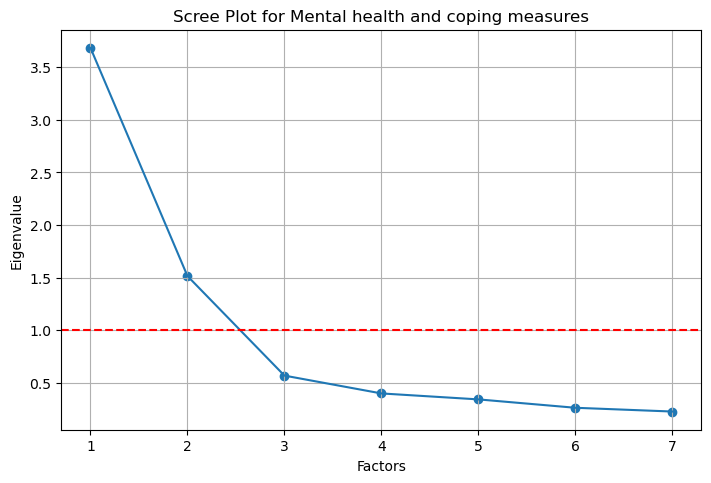

In [103]:
# Create scree plot using matplotlib
fig, axs = plt.subplots(figsize=(8,5))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.5)
axs.scatter(range(1,mental_before_factors[mental_measures_cols].shape[1]+1),ev_mental)
axs.plot(range(1,mental_before_factors[mental_measures_cols].shape[1]+1),ev_mental)
axs.set_title('Scree Plot for Mental health and coping measures')
axs.set_xlabel('Factors')
axs.set_ylabel('Eigenvalue')
axs.axhline(y = 1, color = 'r', linestyle = '--') 
axs.grid()


In [105]:
fa_war = FactorAnalyzer(n_factors=2,rotation="oblimin")
fa_war.fit(war_before_factors[war_measures_cols])
fa_war_load = pd.DataFrame(fa_war.loadings_,index=war_before_factors[war_measures_cols].columns)

fa_mental = FactorAnalyzer(n_factors=2, rotation="oblimin")
fa_mental.fit(mental_before_factors[mental_measures_cols])
fa_mental_load = pd.DataFrame(fa_mental.loadings_,index=mental_before_factors[mental_measures_cols].columns)

fa_war_load
fa_mental.get_uniquenesses() #if this value is large it means that it less importance than the others, in this case 

array([0.34728488, 0.42250141, 0.21577464, 0.28642604, 0.40142894,
       0.26411295, 0.58267149])

In [107]:
print(pd.DataFrame(fa_war.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                         0         1
Variance          0.732809  0.584091
Proportional Var  0.122135  0.097348
Cumulative Var    0.122135  0.219483


There two eigenvalues that higher that 1, so we got 2 factor for war measures: 
1. The first factor has high loadings for reserve duty and know victims. 
2. The second factor has high loadings for sirens work changes and know victims also.

Total 22% cumulative Variance explained by the 2 factors.


In [110]:
fa_mental_load

,0,1
anxiety,0.807302,0.031291
stress,0.757384,0.062194
depression,0.871089,-0.159463
pcl,0.842587,0.060181
problems,-0.052181,0.771912
emotional,0.056199,0.855996
avoidance,0.629905,0.143348


In [112]:
print(pd.DataFrame(fa_mental.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                         0         1
Variance          3.096777  1.383023
Proportional Var  0.442397  0.197575
Cumulative Var    0.442397  0.639971


There two eigenvalues that higher that 1, so we got 2 factor for mental measures: 
1. The first factor has high loadings for anxiety, depression, stress and pcl. 
2. The second factor has high loadings for problems, emotional and avoidance (COPE MECHANISMS).

Total 65% cumulative Variance explained by the 2 factors.

## Visualize the factors in war and mental in attention measures

In [116]:
# create the dividsion for asrs score into two groups (sympthoms and without)
asrs_binar_score = pd.DataFrame()
asrs_binar_score['uniqueID'] = subjective_df['uniqueID']
asrs_binar_score['asrs'] = subjective_df['asrs']
asrs_binar_score.loc[asrs_binar_score['asrs'] <= 51,'asrs'] = '0'
asrs_binar_score.loc[asrs_binar_score['asrs'].astype('int64') > 51, 'asrs'] = '1'

# create the dividsion for phasic alertness score into two groups (above 0 and below 0)
pa_binar_score = pd.DataFrame()
pa_binar_score['uniqueID'] = dataset_of_new_factors['uniqueID']
pa_binar_score['phasic_alertness'] = dataset_of_new_factors['phasic_alertness']
pa_binar_score.loc[pa_binar_score['phasic_alertness'] <= 0,'phasic_alertness'] = '0'
pa_binar_score.loc[pa_binar_score['phasic_alertness'].astype('float32') > 0, 'phasic_alertness'] = '1'

# create the dividsion for executive control score into two groups (accordign to mean)
mean_score = np.mean(dataset_of_new_factors['executive_control'])
ec_binar_score = pd.DataFrame()
ec_binar_score['uniqueID'] = dataset_of_new_factors['uniqueID']
ec_binar_score['executive_control'] = dataset_of_new_factors['executive_control']
ec_binar_score.loc[ec_binar_score['executive_control'] > mean_score, 'executive_control'] = '1'
ec_binar_score.loc[ec_binar_score['executive_control'].astype('float64') <= mean_score,'executive_control'] = '0'


In [118]:
# find the new data points for the factors we found and add the uniqueID column back
war_after_factors = fa_war.transform(war_before_factors[war_measures_cols])
war_after_factors_df = pd.DataFrame(war_after_factors)
unique_ids_war = np.array(war_before_factors['uniqueID'])
war_after_factors_df.insert(2,'uniqueID',unique_ids_war,True)

# create new dataframe combained of the factors ponits and the asrs group
war_factor_asrs = pd.merge(war_after_factors_df,asrs_binar_score,on='uniqueID')
group_without_sympthoms_war = war_factor_asrs.loc[war_factor_asrs['asrs'].astype('int64') == 0]
group_with_sympthoms_war = war_factor_asrs.loc[war_factor_asrs['asrs'].astype('int64') == 1]


# find the new data points for the factors we found and add the uniqueID column back
mental_after_factors = fa_mental.transform(mental_before_factors[mental_measures_cols])
mental_after_factors_df = pd.DataFrame(mental_after_factors)
unique_ids_mental = np.array(mental_before_factors['uniqueID'])
mental_after_factors_df.insert(2,'uniqueID',unique_ids_mental,True)

# create new dataframe combained of the factors ponits and the asrs group
mental_factor_asrs = pd.merge(mental_after_factors_df,asrs_binar_score,on='uniqueID')
group_without_sympthoms_mental = mental_factor_asrs.loc[mental_factor_asrs['asrs'].astype('int64') == 0]
group_with_sympthoms_mental = mental_factor_asrs.loc[mental_factor_asrs['asrs'].astype('int64') == 1]


In [120]:
mental_factors_asrs_df = pd.merge(mental_after_factors_df,subjective_df[['uniqueID','asrs']],on='uniqueID')
mental_factors_asrs_df = mental_factors_asrs_df.rename(columns={0: "factor_1", 1: "factor_2"})

In [122]:
data = mental_factors_asrs_df[['factor_1','factor_2','asrs']]

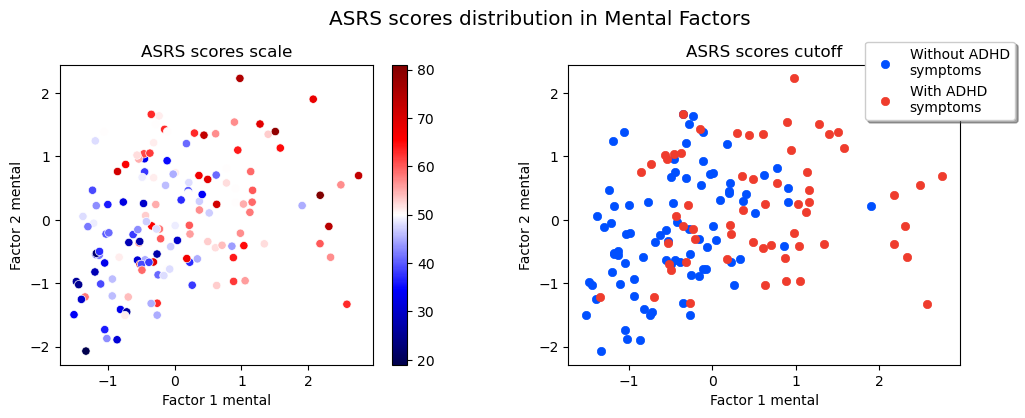

In [128]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.tight_layout(pad=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, wspace=0.3, hspace=0.2)
fig.text(0.5,0.95,'ASRS scores distribution in Mental Factors', ha='center', fontsize='x-large')

sns.scatterplot(data=data, x='factor_1', y="factor_2", hue="asrs",palette="seismic", ax=axs[0])
axs[0].set_xlabel('Factor 1 mental')
axs[0].set_ylabel('Factor 2 mental')
axs[0].legend_.remove()
axs[0].set_title('ASRS scores scale')
#axs[0].legend(loc='upper center', bbox_to_anchor=(1, 1.1),ncol=1, fancybox=True, shadow=True)

axs[1].scatter(group_without_sympthoms_mental[0],group_without_sympthoms_mental[1], color='#004fff',
               linewidths=0.5, label='Without ADHD\nsymptoms')
axs[1].scatter(group_with_sympthoms_mental[0],group_with_sympthoms_mental[1], color='#EF3C2D',
               linewidths=0.5, label='With ADHD\nsymptoms')
axs[1].set_xlabel('Factor 1 mental')
axs[1].set_ylabel('Factor 2 mental')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.95, 1.1),ncol=1, fancybox=True, shadow=True)
axs[1].set_title('ASRS scores cutoff')
#Colormap for comparison
cmap = plt.get_cmap("seismic")
norm = plt.Normalize(np.min(data['asrs']),np.max(data['asrs']))
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[0])

/var/folders/wk/jg2bxmbj4h18w0rtwyjc8dvr0000gn/T/ipykernel_47288/3449281659.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=4.5)


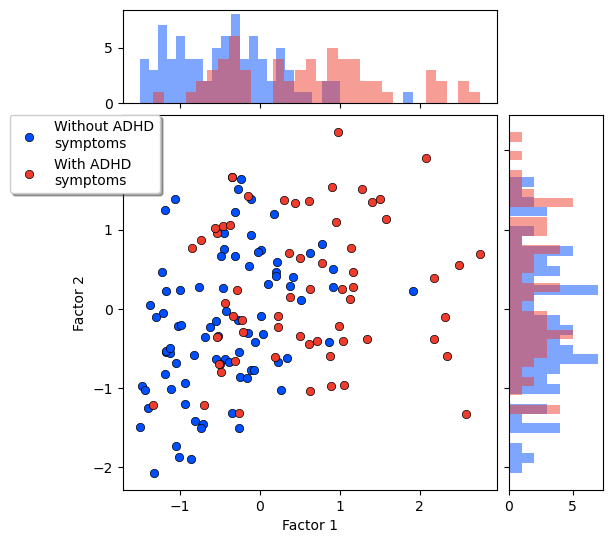

In [132]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, color, label):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, wspace=0.3, hspace=0.2)
    fig.tight_layout(pad=4.5)
    ax.scatter(x, y, color=color, edgecolors="black", linewidths=0.5, label=label)
    ax.legend(loc='upper center', bbox_to_anchor=(-0.1, 1.02),ncol=1, fancybox=True, shadow=True)
    ax.set_xlabel('Factor 1')
    ax.set_ylabel('Factor 2')
    # now determine nice limits by hand:
    #binwidth = 0.25
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=30, alpha=0.5, color=color)
    ax_histy.hist(y, bins=30, alpha=0.5, color=color, orientation='horizontal')




fig = plt.figure(figsize=(6, 6))
fig.tight_layout(pad=2.5)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(group_without_sympthoms_mental[0], group_without_sympthoms_mental[1], ax, ax_histx, ax_histy, color='#004fff',label='Without ADHD\nsymptoms')
scatter_hist(group_with_sympthoms_mental[0], group_with_sympthoms_mental[1], ax, ax_histx, ax_histy, color='#EF3C2D',label='With ADHD\nsymptoms')



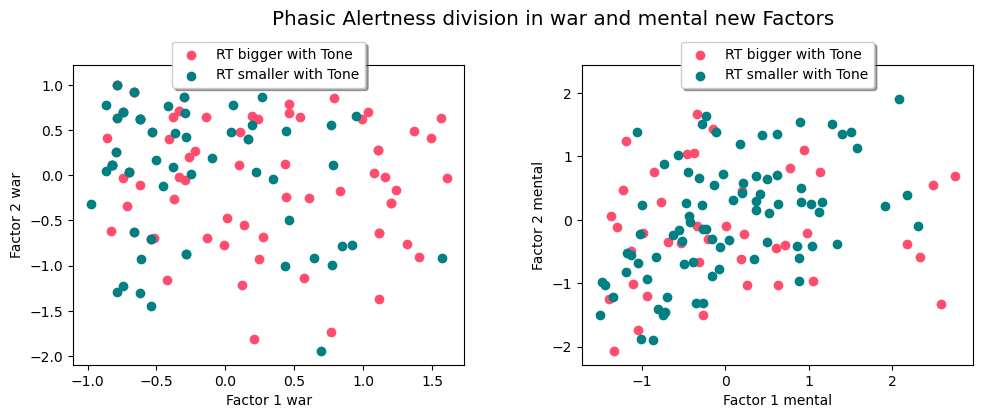

In [134]:
# create new dataframe combained of the factors ponits and the asrs group
mental_factor_pa = pd.merge(mental_after_factors_df,pa_binar_score,on='uniqueID')
group_without_sympthoms_mental = mental_factor_pa.loc[mental_factor_pa['phasic_alertness'].astype('int64') == 0]
group_with_sympthoms_mental = mental_factor_pa.loc[mental_factor_pa['phasic_alertness'].astype('int64') == 1]



# plot the new factor with phasic alertness groups separation
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.tight_layout(pad=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, wspace=0.3, hspace=0.2)
fig.text(0.5,0.95,'Phasic Alertness division in war and mental new Factors', ha='center', fontsize='x-large')

axs[0].scatter(group_without_sympthoms_war[0],group_without_sympthoms_war[1], color='#FF4D6D', label='RT bigger with Tone')
axs[0].scatter(group_with_sympthoms_war[0],group_with_sympthoms_war[1], color='#008083', label='RT smaller with Tone')
axs[0].set_xlabel('Factor 1 war')
axs[0].set_ylabel('Factor 2 war')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=1, fancybox=True, shadow=True)
#axs[0].set_title('War Factors')
axs[1].scatter(group_without_sympthoms_mental[0],group_without_sympthoms_mental[1], color='#FF4D6D', label='RT bigger with Tone')
axs[1].scatter(group_with_sympthoms_mental[0],group_with_sympthoms_mental[1], color='#008083', label='RT smaller with Tone')
axs[1].set_xlabel('Factor 1 mental')
axs[1].set_ylabel('Factor 2 mental')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=1, fancybox=True, shadow=True)
#axs[1].set_title('Mental Factors')

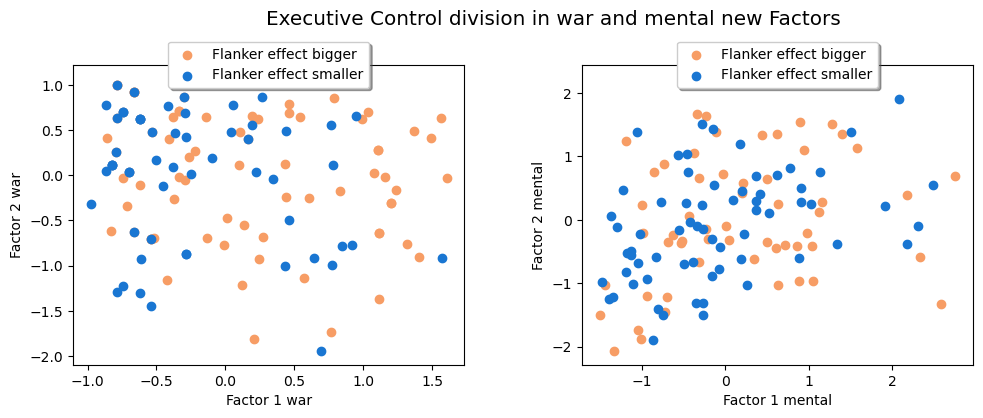

In [136]:
# create new dataframe combained of the factors ponits and the asrs group
mental_factor_ec = pd.merge(mental_after_factors_df,ec_binar_score,on='uniqueID')
group_without_sympthoms_mental = mental_factor_ec.loc[mental_factor_ec['executive_control'].astype('int64') == 0]
group_with_sympthoms_mental = mental_factor_ec.loc[mental_factor_ec['executive_control'].astype('int64') == 1]


# plot the new factor with executive control groups separation
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.tight_layout(pad=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, wspace=0.3, hspace=0.2)
fig.text(0.5,0.95,'Executive Control division in war and mental new Factors', ha='center', fontsize='x-large')

axs[0].scatter(group_without_sympthoms_war[0],group_without_sympthoms_war[1], color='#f79d65', label='Flanker effect bigger')
axs[0].scatter(group_with_sympthoms_war[0],group_with_sympthoms_war[1], color='#1976d2', label='Flanker effect smaller')
axs[0].set_xlabel('Factor 1 war')
axs[0].set_ylabel('Factor 2 war')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=1, fancybox=True, shadow=True)
#axs[0].set_title('War Factors')
axs[1].scatter(group_without_sympthoms_mental[0],group_without_sympthoms_mental[1], color='#f79d65', label='Flanker effect bigger')
axs[1].scatter(group_with_sympthoms_mental[0],group_with_sympthoms_mental[1], color='#1976d2', label='Flanker effect smaller')
axs[1].set_xlabel('Factor 1 mental')
axs[1].set_ylabel('Factor 2 mental')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=1, fancybox=True, shadow=True)

# Hierarchical regression analysis
For this analysis I used JASP and SPSS <br>
<br>
That it....